# 1 - Preprocessing and simple models

## Group 1

Mikołaj Jarząbkowski | 20230529 <br>
Rodrigo Silva | 20230536 <br>
Nicolau Dulea | 20230544 <br>
Joana Gonçalves | 20230977 <br>
Tiago Fernandes | 20230988 <br>

## Imports

In [1]:
from numpy.random import seed
seed(42)
import pandas as pd
import numpy as np
import os, shutil
import io
import seaborn as sns
import requests
import urllib
import bs4
import re
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# keras
#! pip install tensorflow
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.random import set_seed
tensorflow.random.set_seed(42)
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate, RandomRotation, RandomZoom,Rescaling, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, models, callbacks, layers
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")

# Data exploration and preprocessing

In [ ]:
df = pd.read_csv("fitzpatrick17k.csv")

In [ ]:
# Dropping out the rows in column "url" that have NaN values, and saving them for maybe a usage in future
url_droped = df[df["url"].isna()]
df.dropna(subset = ["url"], inplace = True)

# Dropping out the "md5hash", does look necessary
df.drop(columns = "md5hash",inplace = True)

# Dropping out all bar Diagnostic since we dont like it because or its Wrongly labelled or Potentially and we  dont want to do a model with potentially
df = df[~df['qc'].isin(["5 Potentially", "2 Characteristic", "3 Wrongly labelled", "4 Other"])]

# Dropping out "url_alphanum", it has no use for the training part
df.drop(columns = "url_alphanum", inplace = True)

In [ ]:
df

,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url
0,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...
1,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...
2,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...
3,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...
4,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...
...,...,...,...,...,...,...,...
16572,5,5,scleroderma,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=4529
16573,4,5,pityriasis rosea,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=5630
16574,3,3,myiasis,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=4609
16575,-1,5,vitiligo,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=7930


In [ ]:
# Encode categorical features
categorical_feats = ['nine_partition_label', 'three_partition_label']
df= pd.get_dummies(df, columns=categorical_feats)

df.replace(False, 0, inplace=True)
df.replace(True, 1, inplace=True)

In [ ]:
X = df.drop(columns=['label'])
y = df['label']

# Splitting into train and test sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Further splitting the training set into train and validation sets (70% train, 15% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42, stratify=y_train) # 0.18 x 0.85 ~ 0.15

In [ ]:
# Drop indexes not working
indexes_not_working = [12847,13186,13244,13353,13357,13846,13811,14146,15278,15556]

for index in indexes_not_working:
    if index in X_train.index:
        X_train = X_train.drop(index=index)
        y_train = y_train.drop(index=index)
    elif index in X_val.index:
        X_val = X_val.drop(index=index)
        y_val = y_val.drop(index=index)
    else:
        X_test = X_test.drop(index=index)
        y_test = y_test.drop(index=index)

In [ ]:
X_val

,fitzpatrick_scale,fitzpatrick_centaur,qc,url,nine_partition_label_benign dermal,nine_partition_label_benign epidermal,nine_partition_label_benign melanocyte,nine_partition_label_genodermatoses,nine_partition_label_inflammatory,nine_partition_label_malignant cutaneous lymphoma,nine_partition_label_malignant dermal,nine_partition_label_malignant epidermal,nine_partition_label_malignant melanoma,three_partition_label_benign,three_partition_label_malignant,three_partition_label_non-neoplastic
7477,1,1,NaN,https://www.dermaamin.com/site/images/clinical...,0,0,0,0,0,0,0,0,1,0,1,0
3170,3,2,NaN,https://www.dermaamin.com/site/images/clinical...,0,0,0,0,1,0,0,0,0,0,0,1
10411,1,1,NaN,https://www.dermaamin.com/site/images/clinical...,0,0,0,0,1,0,0,0,0,0,0,1
7892,4,4,NaN,https://www.dermaamin.com/site/images/clinical...,0,0,0,0,1,0,0,0,0,0,0,1
12772,6,6,NaN,http://atlasdermatologico.com.br/img?imageId=5733,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,1,2,NaN,https://www.dermaamin.com/site/images/clinical...,0,0,0,0,1,0,0,0,0,0,0,1
4440,4,1,NaN,https://www.dermaamin.com/site/images/clinical...,0,0,1,0,0,0,0,0,0,1,0,0
7557,5,4,NaN,https://www.dermaamin.com/site/images/clinical...,0,0,0,0,1,0,0,0,0,0,0,1
7866,5,4,NaN,https://www.dermaamin.com/site/images/clinical...,0,0,0,0,1,0,0,0,0,0,0,1


### Function to download images

In [ ]:
def download_images(partition):
    """
    This notepad needs to be executed in the same notepad where we did train_test_split,
    so it recognizes the partition(X_train,X_test,X_val), and also the label(y_train,y_test,y_val).
    """
    partitions = [
    ("X_train", X_train,y_train),
    ("X_test", X_test,y_test),
    ("X_val", X_val,y_val)]

    label_column = None
    partition_name = None
    for name, df, label in partitions:
        if partition is df:
            partition_name = name
            label_column = label

    # Create folder if doesn't exist
    os.makedirs(partition_name, exist_ok=True)
    os.makedirs("X_train_diag", exist_ok=True)
    os.makedirs("X_train_aug",exist_ok = True)
    # Function to sanitize the filename
    def sanitize_filename(filename):
        return re.sub(r'[^\w\-_.]', '_', filename)

    # Iterate over the DataFrame rows
    for index, row in partition.iterrows():
        label = label_column.loc[index]
        image_url = row['url']
        file_name = sanitize_filename(image_url.split("/")[-1])

        if row["qc"] == '1 Diagnostic' and partition_name == "X_train":
            file_name = f"diagnost_{file_name}"
            folder_path = os.path.join("X_train_diag", label)
            save_path = os.path.join(folder_path, file_name)
        else:
            folder_path = os.path.join(partition_name, label)
            save_path = os.path.join(folder_path, file_name)

        # Check if the image file already exists
        if not os.path.exists(save_path):
            # Define headers to mimic a browser request
            headers = {'User-Agent': 
                       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
            # Send a GET request to the URL to retrieve the image data
            response = requests.get(image_url, headers=headers)

            # Create a folder for the label if it doesn't exist
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            # Check if the request was successful
            if "atlasdermatologico.com.br" in image_url:
                if response.status_code == 200:
                    # Open the image using PIL (Python Imaging Library)
                    image = Image.open(BytesIO(response.content))
                    image.save(f"{save_path}.jpg")
                else:
                    print("Failed to download image for lab")
            else:
                if response.status_code == 200:
                    # Save the image inside the folder
                    with open(save_path, 'wb') as f:
                        f.write(response.content)
                else:
                    print("Failed to download image for label")
        else:
            print("Image already exists for label")

In [ ]:
# Download images for train, val and test
download_images(X_train)
download_images(X_val)
download_images(X_test)

Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image already exists for label
Image al

ReadTimeout: HTTPSConnectionPool(host='atlasdermatologico.com.br', port=443): Read timed out. (read timeout=None)

In [ ]:
# Drop columns url and qc, we don't need them anymore
X_train.drop(columns = ["url","qc"],inplace = True)
X_test.drop(columns = ["url","qc"],inplace = True)
X_val.drop(columns = ["url","qc"],inplace = True)

If all has gone well, our dataframes should be clean and the images downloaded into their folders.

### Getting the number of images that are diagnostic for each label

In [ ]:
root_dir = 'X_train_diag'
image_counts = {}
subfolder_labels = {}

for subdir, dirs, files in os.walk(root_dir):
    folder_name = os.path.basename(subdir)


    subfolder_labels[folder_name] = folder_name


    num_images = len([file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))])


    image_counts[folder_name] = num_images

In [ ]:
image_counts

{'X_train_diag': 0,
 'acanthosis nigricans': 5,
 'acne': 4,
 'acne vulgaris': 3,
 'acrodermatitis enteropathica': 1,
 'actinic keratosis': 6,
 'allergic contact dermatitis': 3,
 'basal cell carcinoma': 12,
 'basal cell carcinoma morpheiform': 2,
 'cheilitis': 1,
 'congenital nevus': 1,
 'dariers disease': 2,
 'dermatomyositis': 2,
 'disseminated actinic porokeratosis': 3,
 'drug eruption': 3,
 'eczema': 4,
 'ehlers danlos syndrome': 4,
 'epidermal nevus': 1,
 'erythema elevatum diutinum': 1,
 'erythema multiforme': 5,
 'factitial dermatitis': 2,
 'fixed eruptions': 1,
 'folliculitis': 3,
 'granuloma annulare': 2,
 'hailey hailey disease': 4,
 'ichthyosis vulgaris': 2,
 'incontinentia pigmenti': 2,
 'kaposi sarcoma': 3,
 'keloid': 4,
 'keratosis pilaris': 2,
 'lentigo maligna': 2,
 'lichen amyloidosis': 1,
 'lichen planus': 7,
 'lichen simplex': 2,
 'lupus erythematosus': 6,
 'lyme disease': 1,
 'lymphangioma': 2,
 'malignant melanoma': 1,
 'melanoma': 4,
 'milia': 1,
 'mucous cyst': 1,

In [ ]:
del image_counts["X_train_diag"]

### Create directory and its subfolders

In [ ]:
root_dir = 'X_train'
output_dir = 'X_train_aug'
output_dir2 = 'X_train_diag_aug'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if not os.path.exists(output_dir2):
    os.makedirs(output_dir2)

# Iterate through each subfolder in root_dir
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        relative_subdir = os.path.relpath(subdir, root_dir)
        output_subdir = os.path.join(output_dir, relative_subdir)
        output_subdir2 = os.path.join(output_dir2, relative_subdir)

        if not os.path.exists(output_subdir):
            os.makedirs(output_subdir)
        if not os.path.exists(output_subdir2):
            os.makedirs(output_subdir2)

In [2]:
# Create a dict with the amount of images we need to create to balance the classes

root_dir = 'X_train'
image_counts_2 = {}
subfolder_labels = {}

# Getting the number of images in each class not counting the diagnosys ones
for subdir, dirs, files in os.walk(root_dir):
    folder_name = os.path.basename(subdir)


    subfolder_labels[folder_name] = folder_name


    num_images = len([file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))])


    image_counts_2[folder_name] = num_images

del image_counts_2["X_train"]

In [ ]:
image_counts_2

{'acanthosis nigricans': 59,
 'acne': 122,
 'acne vulgaris': 231,
 'acquired autoimmune bullous diseaseherpes gestationis': 43,
 'acrodermatitis enteropathica': 63,
 'actinic keratosis': 116,
 'allergic contact dermatitis': 289,
 'aplasia cutis': 50,
 'basal cell carcinoma': 314,
 'basal cell carcinoma morpheiform': 41,
 'becker nevus': 44,
 'behcets disease': 43,
 'calcinosis cutis': 55,
 'cheilitis': 72,
 'congenital nevus': 47,
 'dariers disease': 101,
 'dermatofibroma': 55,
 'dermatomyositis': 101,
 'disseminated actinic porokeratosis': 39,
 'drug eruption': 131,
 'drug induced pigmentary changes': 48,
 'dyshidrotic eczema': 58,
 'eczema': 138,
 'ehlers danlos syndrome': 84,
 'epidermal nevus': 62,
 'epidermolysis bullosa': 47,
 'erythema annulare centrifigum': 62,
 'erythema elevatum diutinum': 37,
 'erythema multiforme': 158,
 'erythema nodosum': 57,
 'factitial dermatitis': 42,
 'fixed eruptions': 86,
 'folliculitis': 232,
 'fordyce spots': 70,
 'granuloma annulare': 144,
 'gran

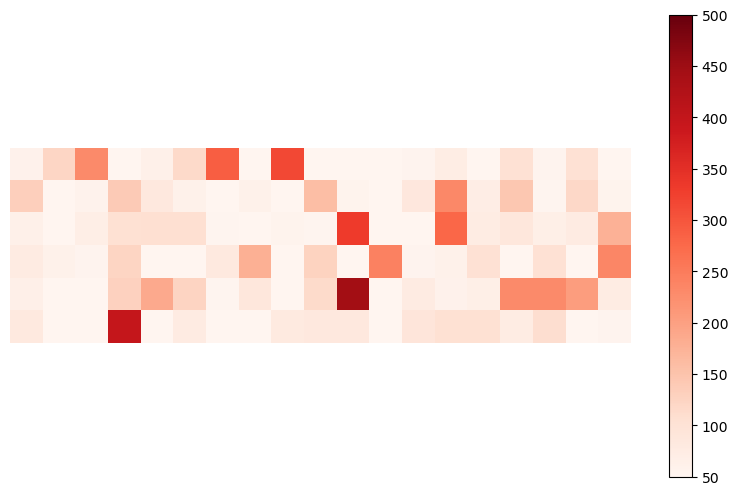

In [25]:
# Visualization for difference in classes

values = [image_counts_2[key] for key in image_counts_2]

grid_values = np.array(values).reshape(6, 19)

# Plot the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(grid_values, cmap='Reds', interpolation='nearest', vmin=50, vmax=500)
plt.colorbar()  # Add color bar
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
max_class = max(image_counts_2, key=lambda x: image_counts_2[x])

images_needed_class =  {}
for key, value in image_counts_2.items():
    images_needed_class[key] = image_counts_2[max_class] - value

del images_needed_class[max(image_counts, key=image_counts.get)]

### Create images with data augm. for images that we are sure that are correctly diagnosed

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='reflect')

for label, value in image_counts.items():
    i = 0
    for batch in train_datagen.flow_from_directory('X_train_diag',
                                                   target_size=(224,224),
                                                   classes=[label],
                                                   save_to_dir=f"X_train_diag_aug/{label}",
                                                   batch_size=15,
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   save_prefix="aug_",
                                                   save_format="jpg",
                                                   shuffle=True):
        i += 1
        if i >= 15:
            break

    if label in images_needed_class.keys() and label in image_counts.keys():
        images_needed_class[label] -= (15 * value)

# 15 of each because looked a good number, and to make sure that is bigger than the numbers of the same image we gonna augment,
# because we are not sure that those are mislabeled or not"""

### Create the rest of the images, with the images we are not sure are correctly labeled

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='reflect')

for label, value in images_needed_class.items():
    i = 0

    # Getting the number of how many images we need to create from just 1 image for each label
    ratio = value / image_counts_2[label]
    num_images_to_generate = math.ceil(ratio)

    for batch in train_datagen.flow_from_directory('X_train',
                                                   target_size=(224,224),
                                                   classes=[label],
                                                   save_to_dir=f"X_train_aug/{label}",
                                                   batch_size=num_images_to_generate,
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   save_prefix="aug_",
                                                   save_format="jpg",
                                                   shuffle=True):
        i += 1
        if i >= num_images_to_generate:
            break

### Merge all the images into a final folder to train

In [ ]:
# Define folder paths
X_train_path = "X_train"
X_train_aug_path = "X_train_aug"
X_train_diag_aug_path = "X_train_diag_aug"
X_train_final_aug_path = "X_train_final_aug"

# Create X_train_final_aug if it doesn't exist
if not os.path.exists(X_train_final_aug_path):
    os.makedirs(X_train_final_aug_path)


def copy_files(source_dir, destination_dir):
    for root, dirs, files in os.walk(source_dir):
        rel_path = os.path.relpath(root, source_dir)
        dest_path = os.path.join(destination_dir, rel_path)
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)
        for file in files:
            src_path = os.path.join(root, file)
            dest_file_path = os.path.join(dest_path, file)
            shutil.copy2(src_path, dest_file_path)

# Copy files from X_train to X_train_final_aug
copy_files(X_train_path, X_train_final_aug_path)

# Copy files from X_train_aug to X_train_final_aug
copy_files(X_train_aug_path, X_train_final_aug_path)

# Copy files from X_train_diag_aug to X_train_final_aug
copy_files(X_train_diag_aug_path, X_train_final_aug_path)

'/content/drive/MyDrive/DL/X_train_final'

### Merging both X_train and X_train_diag, having our X_train_inicial

In [ ]:
X_train_path = "X_train"
X_train_diag_path = "X_train_diag"
X_train_initial_path = "X_train_initial"

if not os.path.exists(X_train_initial_path):
    os.makedirs(X_train_initial_path)

def copy_files(source_dir, destination_dir):
    for root, dirs, files in os.walk(source_dir):
        rel_path = os.path.relpath(root, source_dir)
        dest_path = os.path.join(destination_dir, rel_path)
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)
        for file in files:
            src_path = os.path.join(root, file)
            dest_file_path = os.path.join(dest_path, file)
            shutil.copy2(src_path, dest_file_path)
            
copy_files(X_train_path, X_train_initial_path)

copy_files(X_train_diag_path, X_train_initial_path)

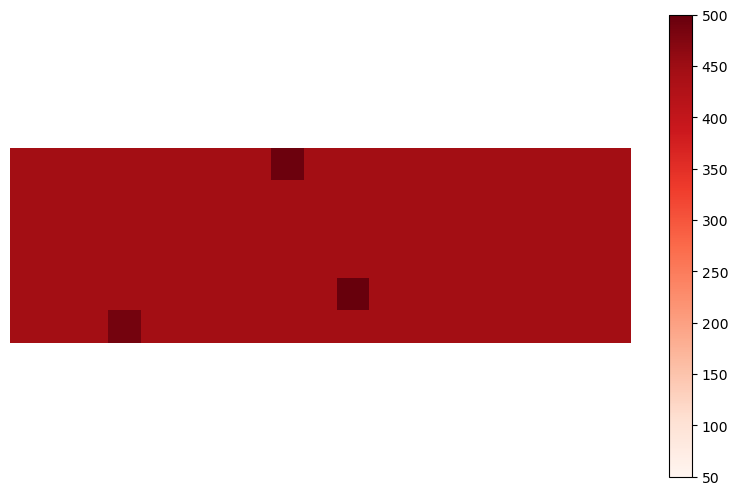

In [24]:
# Visualization of number of images per class after data augmentation

root_dir = 'X_train_final_aug'
image_counts_3 = {}
subfolder_labels = {}

# Getting the number of images in each class not counting the diagnosys ones
for subdir, dirs, files in os.walk(root_dir):
    folder_name = os.path.basename(subdir)


    subfolder_labels[folder_name] = folder_name


    num_images = len([file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))])


    image_counts_3[folder_name] = num_images

del image_counts_3['X_train_final_aug']


values = [image_counts_3[key] for key in image_counts_3]

grid_values = np.array(values).reshape(6, 19)

# Plot the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(grid_values, cmap='Reds', interpolation='nearest', vmin=50, vmax=500)
plt.colorbar()  # Add color bar
plt.axis('off')  # Turn off axis
plt.show()

## Functions that will be used for modelling

#### Function to import images

In [ ]:
def import_images(with_data_augmentation, batch_size, image_size=(224, 224)):
    """
    Parameters:
        batch_size (int): Batch size to be used.
        image_size (tuple): Size of the images (width, height) - By default is (256, 256).

    Returns:
        train_generator : Training dataset generator.
        val_generator : Validation dataset generator.
        image_size (tuple): Size of the images.
    """
    if with_data_augmentation.lower() != "yes":
        train_generator = tf.keras.utils.image_dataset_from_directory("X_train_final",batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)
    else:
        train_generator = tf.keras.utils.image_dataset_from_directory("X_train_final_aug",batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)

    train_generator = train_generator.map(lambda x,y: (x/255, y))

    val_generator = tf.keras.utils.image_dataset_from_directory("X_val", batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)
    val_generator = val_generator.map(lambda x,y: (x/255, y))

    return train_generator, val_generator, image_size

#### Function to create the model

In [ ]:
def build_model(conv_params, dense_params,learning_rate=0.0001, dropout=0):
    """
    Parameters:
        conv_params (tuple): Tuple containing information about convolutional layers.
                             Format: (n_conv2d, filters_conv2d)
            n_conv2d (int): Number of convolutional layers.
            filters_conv2d (tuple): Tuple of number of filters for each convolutional layer.
        dense_params (tuple): Tuple containing information about dense layers.
                              Format: (n_dense, units_dense)
            n_dense (int): Number of dense layers.
            units_dense (list): List of number of units/neurons for each dense layer.
        dropout (float): Dropout rate.

    Returns:
        model: Neural network model.
    """
    num_classes = 114
    input_shape = (import_results[2][0], import_results[2][1], 3)

    conv_layers = []

    if type(conv_params[1]) == int or len(conv_params[1]) == 1:
        conv_layers.extend([
                Conv2D(conv_params[1], (3, 3), activation='relu', input_shape=input_shape),
                MaxPooling2D((2, 2))
            ])

    else:
        for i in range(conv_params[0]):
            if i == 0:
                conv_layers.extend([
                    Conv2D(conv_params[1][i], (3,3), activation='relu', input_shape=input_shape),
                    MaxPooling2D((2, 2))
                ])
            else:
                conv_layers.extend([
                    Conv2D(conv_params[1][i], (3,3), activation='relu'),
                    MaxPooling2D((2, 2))
                ])


    dense_layers = []
    if type(dense_params[1]) == int or len(dense_params[1]) == 1:
        dense_layers.extend([
            Dense(dense_params[1], activation='relu')
        ])
    else:
        for i in range(dense_params[0]):
            dense_layers.extend([
                Dense(dense_params[1][i], activation='relu')
            ])

    model = Sequential([
        *conv_layers,
        Flatten(),
        Dropout(dropout),
        *dense_layers,
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate) , loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
    return model


#### Function to train the model

In [ ]:
def train_model(model, epochs):
    """
    Trains the model for the specified number of epochs.

    Parameters:
        model : The neural network model to train.
        train_generator : The training dataset generator.
        val_generator : The validation dataset generator.
        epochs (int): The number of epochs to train the model for.

    Returns:
         History containing training metrics.
    """
    train_generator,val_generator, _ = import_results
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    hist = model.fit(train_generator, epochs=epochs, callbacks=[callback], validation_data=val_generator)
    return hist

#### Function to get predictions

In [ ]:
def predictions(model, batch_size, image_size):
    test_generator = tf.keras.utils.image_dataset_from_directory("X_test", batch_size= batch_size,
                                                                 image_size=image_size, label_mode="int",
                                                                 seed=42, shuffle=False)
    label_names = test_generator.class_names
    test_generator = test_generator.map(lambda x, y: (x/255, y))


    true_labels = []
    predicted_labels = []


    for batch in test_generator.as_numpy_iterator():
        X, y = batch
        Y_pred = model.predict(X)
        y_pred = np.argmax(Y_pred, axis=1)


        true_labels.extend(y)
        predicted_labels.extend(y_pred)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    f1 = f1_score(true_labels, predicted_labels, average='micro')
    print("F1 Score:", f1)

#### Function to get the loss graphs

In [ ]:
def history_model(history):
    """
    Plots the training and validation loss and accuracy from the provided history object.

    Parameters:
        history (tf.keras.callbacks.History): History object containing training metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss, "y", label = "Training Loss")
    plt.plot(epochs,val_loss, "r", label = "Validation Loss")
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,acc, "y", label = "Training accuracy")
    plt.plot(epochs,val_acc, "r", label = "Validation accuracy")
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


# Models

## Test image size and batch size

### Model 1.1.1. Simple CNN – image_size (128x128) - batch size=64

In [ ]:
import_results = import_images("no", 64, (128, 128))
model111 = build_model((3, [16, 32, 48]), (1,228))
hist111 = train_model(model111, 20)
predictions(model111, 16, (128, 128))
history_model(hist111)

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 333s 2s/step - loss: 4.5527 - accuracy: 0.0359 - val_loss: 4.4939 - val_accuracy: 0.0439
Epoch 2/20
179/179 [==============================] - 265s 1s/step - loss: 4.4498 - accuracy: 0.0523 - val_loss: 4.4191 - val_accuracy: 0.0515
Epoch 3/20
179/179 [==============================] - 274s 1s/step - loss: 4.3582 - accuracy: 0.0667 - val_loss: 4.3517 - val_accuracy: 0.0607
Epoch 4/20
179/179 [==============================] - 267s 1s/step - loss: 4.2651 - accuracy: 0.0749 - val_loss: 4.3148 - val_accuracy: 0.0659
Epoch 5/20
179/179 [==============================] - 248s 1s/step - loss: 4.1734 - accuracy: 0.0865 - val_loss: 4.2674 - val_accuracy: 0.0735
Epoch 6/20
179/179 [==============================] - 235s 1s/step - loss: 4.0888 - accuracy: 0.1012 - val_loss: 4.2523 - val_accuracy: 0.0758
Epoch 7/20
179/179 [==============================] - 2

UnboundLocalError: cannot access local variable 'true_labels' where it is not associated with a value

Found 2457 files belonging to 114 classes.
1/1 [==============================] - 1s 658ms/step
F1 Score: 0.11233211233211234


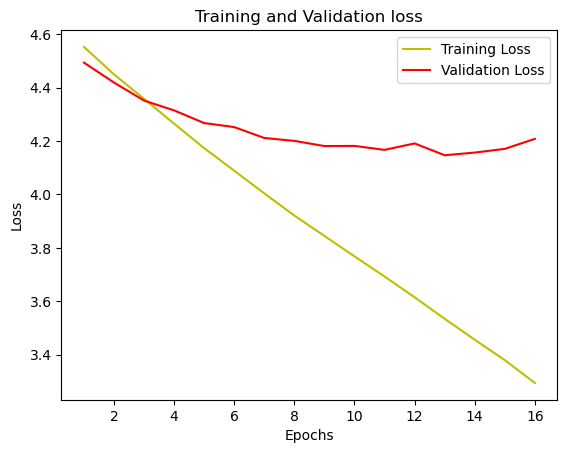

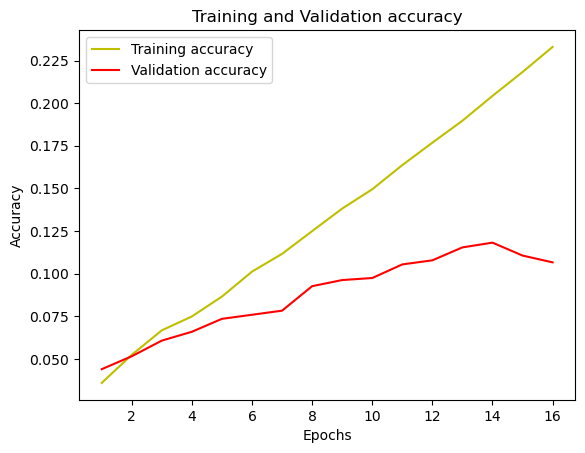

In [ ]:
predictions(model111, 16, (128, 128))
history_model(hist111)

### Model 1.1.2. Simple CNN - image_size (128x128) - batch size=128

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
90/90 [==============================] - 348s 3s/step - loss: 4.6033 - accuracy: 0.0335 - val_loss: 4.5478 - val_accuracy: 0.0455
Epoch 2/20
90/90 [==============================] - 286s 3s/step - loss: 4.5275 - accuracy: 0.0399 - val_loss: 4.5000 - val_accuracy: 0.0499
Epoch 3/20
90/90 [==============================] - 284s 3s/step - loss: 4.4734 - accuracy: 0.0476 - val_loss: 4.4436 - val_accuracy: 0.0571
Epoch 4/20
90/90 [==============================] - 297s 3s/step - loss: 4.4056 - accuracy: 0.0559 - val_loss: 4.3918 - val_accuracy: 0.0643
Epoch 5/20
90/90 [==============================] - 263s 3s/step - loss: 4.3360 - accuracy: 0.0654 - val_loss: 4.3494 - val_accuracy: 0.0603
Epoch 6/20
90/90 [==============================] - 266s 3s/step - loss: 4.2675 - accuracy: 0.0740 - val_loss: 4.3172 - val_accuracy: 0.0619
Epoch 7/20
90/90 [==============================] - 256s 3s/step - 

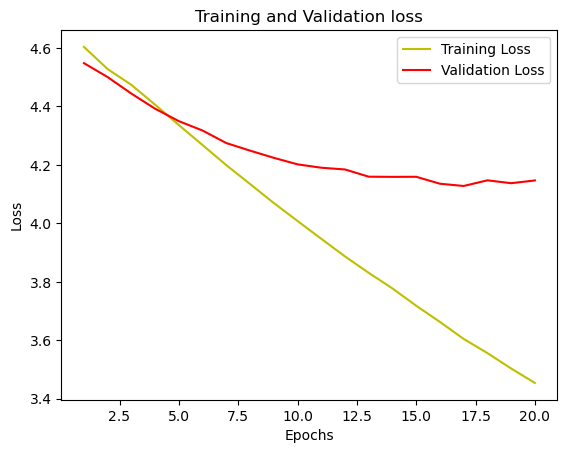

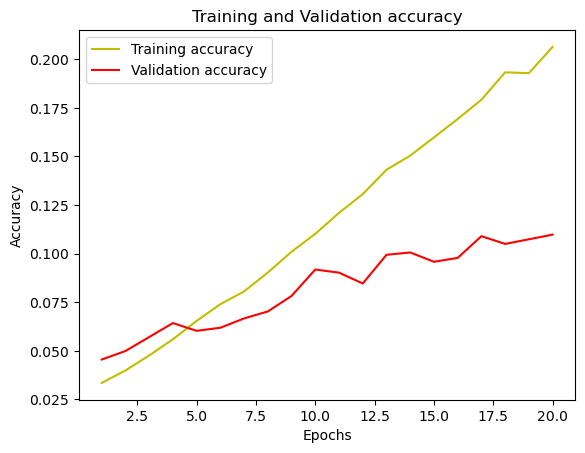

In [ ]:
import_results = import_images("no", 128, (128, 128))
model112 = build_model((3, [16, 32, 48]), (1,228))
hist112 = train_model(model112, 20)
predictions(model112, 32, (128, 128))
history_model(hist112)

### Model 1.1.3. Simple CNN - image_size (96x96) - batch size=64

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 337s 2s/step - loss: 4.5673 - accuracy: 0.0373 - val_loss: 4.5071 - val_accuracy: 0.0423
Epoch 2/20
179/179 [==============================] - 257s 1s/step - loss: 4.4863 - accuracy: 0.0448 - val_loss: 4.4583 - val_accuracy: 0.0471
Epoch 3/20
179/179 [==============================] - 263s 1s/step - loss: 4.4243 - accuracy: 0.0529 - val_loss: 4.4016 - val_accuracy: 0.0531
Epoch 4/20
179/179 [==============================] - 257s 1s/step - loss: 4.3516 - accuracy: 0.0665 - val_loss: 4.3546 - val_accuracy: 0.0547
Epoch 5/20
179/179 [==============================] - 259s 1s/step - loss: 4.2782 - accuracy: 0.0719 - val_loss: 4.3024 - val_accuracy: 0.0655
Epoch 6/20
179/179 [==============================] - 251s 1s/step - loss: 4.2130 - accuracy: 0.0795 - val_loss: 4.2633 - val_accuracy: 0.0679
Epoch 7/20
179/179 [==============================] - 2

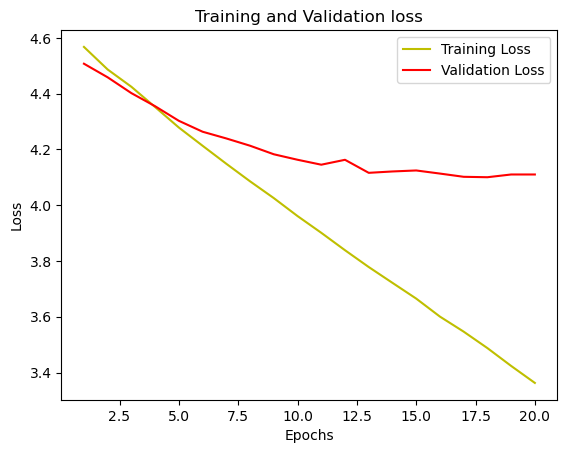

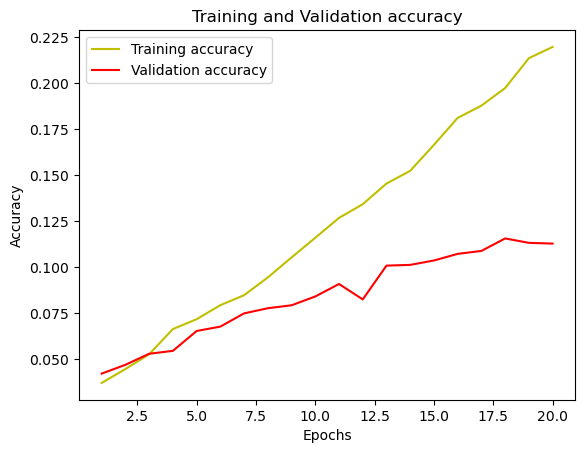

In [ ]:
import_results = import_images("no", 64, (96, 96))
model113 = build_model((3, [16, 32, 48]), (1,228))
hist113 = train_model(model113, 20)
predictions(model113, 16, (96, 96))
history_model(hist113)

### Model 1.1.4. Simple CNN - image_size (96x96) - batch size=128

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
90/90 [==============================] - 331s 3s/step - loss: 4.6062 - accuracy: 0.0320 - val_loss: 4.5266 - val_accuracy: 0.0395
Epoch 2/20
90/90 [==============================] - 270s 3s/step - loss: 4.5129 - accuracy: 0.0384 - val_loss: 4.4914 - val_accuracy: 0.0447
Epoch 3/20
90/90 [==============================] - 247s 2s/step - loss: 4.4755 - accuracy: 0.0451 - val_loss: 4.4538 - val_accuracy: 0.0487
Epoch 4/20
90/90 [==============================] - 224s 2s/step - loss: 4.4291 - accuracy: 0.0519 - val_loss: 4.4230 - val_accuracy: 0.0471
Epoch 5/20
90/90 [==============================] - 241s 2s/step - loss: 4.3759 - accuracy: 0.0645 - val_loss: 4.3815 - val_accuracy: 0.0515
Epoch 6/20
90/90 [==============================] - 238s 2s/step - loss: 4.3182 - accuracy: 0.0695 - val_loss: 4.3504 - val_accuracy: 0.0579
Epoch 7/20
90/90 [==============================] - 267s 3s/step - 

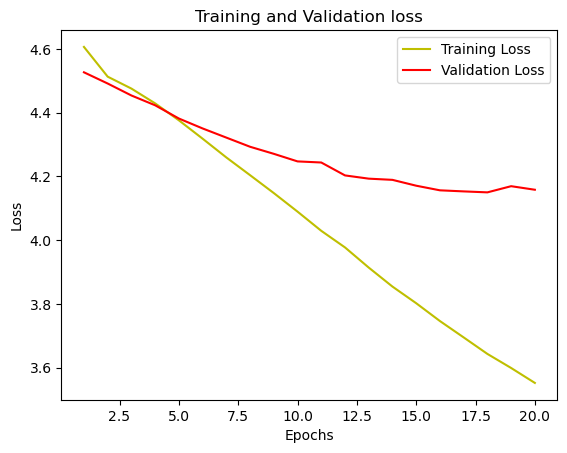

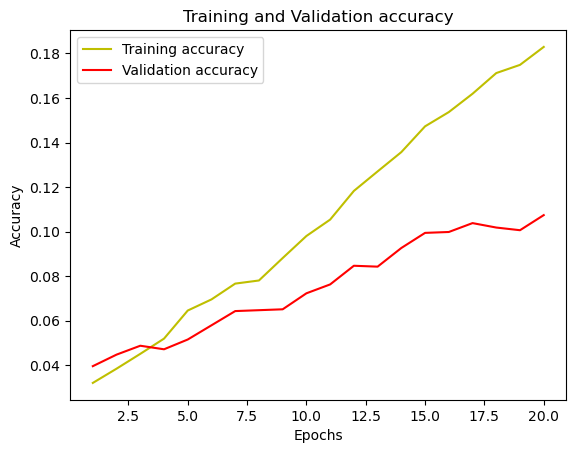

In [ ]:
import_results = import_images("no", 128, (96, 96))
model114 = build_model((3, [16, 32, 48]), (1,228))
hist114 = train_model(model114, 20)
predictions(model114, 32, (96, 96))
history_model(hist114)

## Test dropout

### Model 1.2.1. Simple CNN - image_size (96x96) - batch size=64 + Dropout(0.25)

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 279s 1s/step - loss: 4.5644 - accuracy: 0.0351 - val_loss: 4.5027 - val_accuracy: 0.0443
Epoch 2/20
179/179 [==============================] - 269s 1s/step - loss: 4.4881 - accuracy: 0.0415 - val_loss: 4.4558 - val_accuracy: 0.0471
Epoch 3/20
179/179 [==============================] - 199s 1s/step - loss: 4.4189 - accuracy: 0.0532 - val_loss: 4.3753 - val_accuracy: 0.0555
Epoch 4/20
179/179 [==============================] - 196s 1s/step - loss: 4.3256 - accuracy: 0.0664 - val_loss: 4.3069 - val_accuracy: 0.0559
Epoch 5/20
179/179 [==============================] - 251s 1s/step - loss: 4.2363 - accuracy: 0.0781 - val_loss: 4.2604 - val_accuracy: 0.0615
Epoch 6/20
179/179 [==============================] - 262s 1s/step - loss: 4.1598 - accuracy: 0.0850 - val_loss: 4.2125 - val_accuracy: 0.0754
Epoch 7/20
179/179 [==============================] - 2

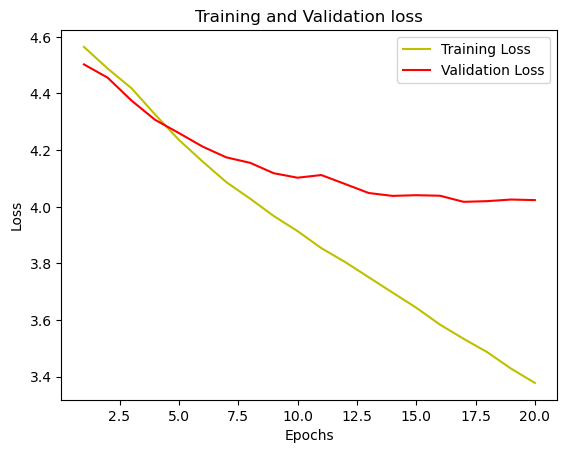

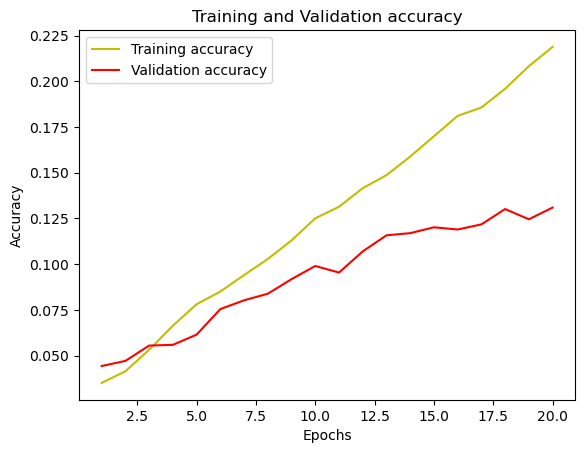

In [ ]:
import_results = import_images("no", 64, (96, 96))
model121 = build_model((3, [16, 32, 48]), (1,228), 0.0001, 0.25)
hist121 = train_model(model121, 20)
predictions(model121, 16, (96, 96))
history_model(hist121)

### Model 1.2.2. Simple CNN - image_size (96x96) - batch size=64 + Dropout(0.35)

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 306s 2s/step - loss: 4.5662 - accuracy: 0.0333 - val_loss: 4.5041 - val_accuracy: 0.0359
Epoch 2/20
179/179 [==============================] - 274s 1s/step - loss: 4.4810 - accuracy: 0.0433 - val_loss: 4.4459 - val_accuracy: 0.0495
Epoch 3/20
179/179 [==============================] - 256s 1s/step - loss: 4.4085 - accuracy: 0.0554 - val_loss: 4.3777 - val_accuracy: 0.0547
Epoch 4/20
179/179 [==============================] - 250s 1s/step - loss: 4.3238 - accuracy: 0.0686 - val_loss: 4.3228 - val_accuracy: 0.0527
Epoch 5/20
179/179 [==============================] - 249s 1s/step - loss: 4.2411 - accuracy: 0.0766 - val_loss: 4.2679 - val_accuracy: 0.0575
Epoch 6/20
179/179 [==============================] - 253s 1s/step - loss: 4.1620 - accuracy: 0.0836 - val_loss: 4.2304 - val_accuracy: 0.0599
Epoch 7/20
179/179 [==============================] - 2

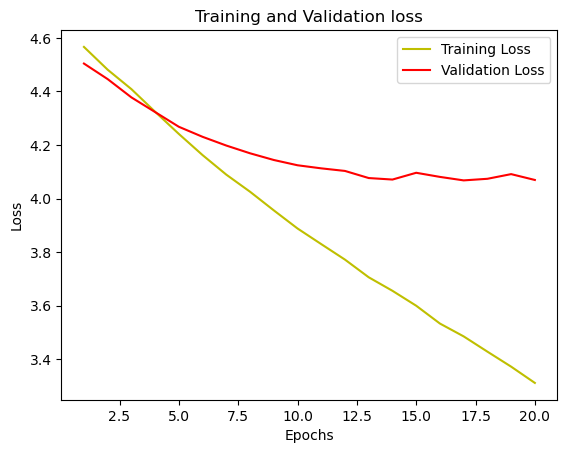

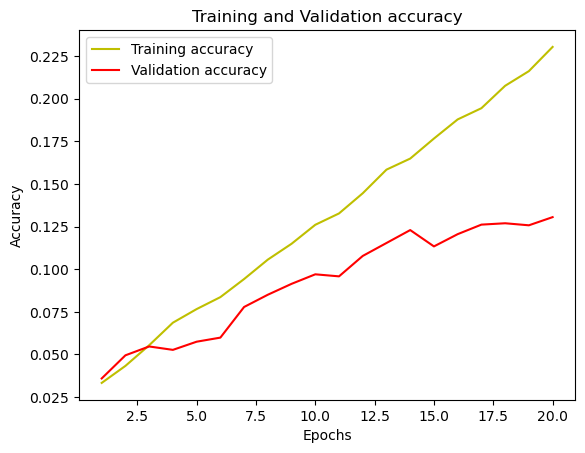

In [ ]:
import_results = import_images("no", 64, (96, 96))
model122 = build_model((3, [16, 32, 48]), (1,228), 0.0001, 0.35)
hist122 = train_model(model122, 20)
predictions(model122, 16, (96, 96))
history_model(hist122)

### Model 1.2.3. Simple CNN - image_size (96x96) - batch size=64 + Dropout(0.5)

In [ ]:
import_results = import_images("no", 64, (96, 96))
model123 = build_model((3, [16, 32, 48]), (1,228), 0.0001, 0.5)
hist123 = train_model(model123, 20)
predictions(model123, 16, (96, 96))
history_model(hist123)

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 62s 321ms/step - loss: 4.5774 - accuracy: 0.0354 - val_loss: 4.5081 - val_accuracy: 0.0399
Epoch 2/20
179/179 [==============================] - 58s 311ms/step - loss: 4.4947 - accuracy: 0.0423 - val_loss: 4.4640 - val_accuracy: 0.0463
Epoch 3/20
179/179 [==============================] - 59s 312ms/step - loss: 4.4366 - accuracy: 0.0522 - val_loss: 4.4080 - val_accuracy: 0.0499
Epoch 4/20
179/179 [==============================] - 57s 309ms/step - loss: 4.3717 - accuracy: 0.0594 - val_loss: 4.3592 - val_accuracy: 0.0523
Epoch 5/20
179/179 [==============================] - 59s 318ms/step - loss: 4.3086 - accuracy: 0.0652 - val_loss: 4.3170 - val_accuracy: 0.0507
Epoch 6/20
179/179 [==============================] - 59s 313ms/step - loss: 4.2492 - accuracy: 0.0745 - val_loss: 4.2856 - val_accuracy: 0.0607
Epoch 7/20
179/179 [=======================

### Model 1.2.4. Simple CNN - image_size (96x96) - batch size=64 + Dropout(0.6)

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 636s 4s/step - loss: 4.5735 - accuracy: 0.0372 - val_loss: 4.5111 - val_accuracy: 0.0391
Epoch 2/20
179/179 [==============================] - 165s 901ms/step - loss: 4.5072 - accuracy: 0.0412 - val_loss: 4.4826 - val_accuracy: 0.0507
Epoch 3/20
179/179 [==============================] - 162s 885ms/step - loss: 4.4624 - accuracy: 0.0459 - val_loss: 4.4300 - val_accuracy: 0.0475
Epoch 4/20
179/179 [==============================] - 191s 1s/step - loss: 4.3991 - accuracy: 0.0550 - val_loss: 4.3826 - val_accuracy: 0.0515
Epoch 5/20
179/179 [==============================] - 188s 1s/step - loss: 4.3284 - accuracy: 0.0639 - val_loss: 4.3246 - val_accuracy: 0.0567
Epoch 6/20
179/179 [==============================] - 170s 926ms/step - loss: 4.2649 - accuracy: 0.0683 - val_loss: 4.2790 - val_accuracy: 0.0579
Epoch 7/20
179/179 [==========================

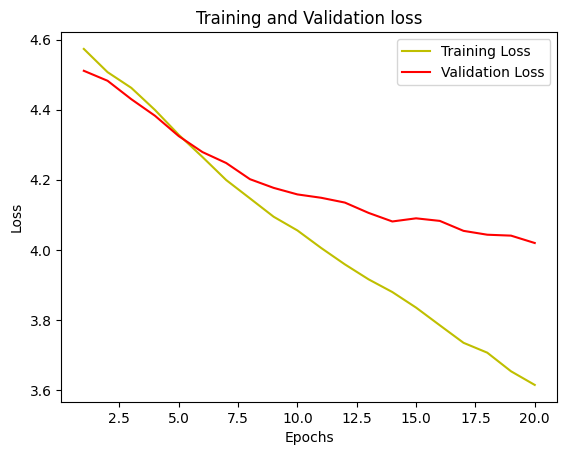

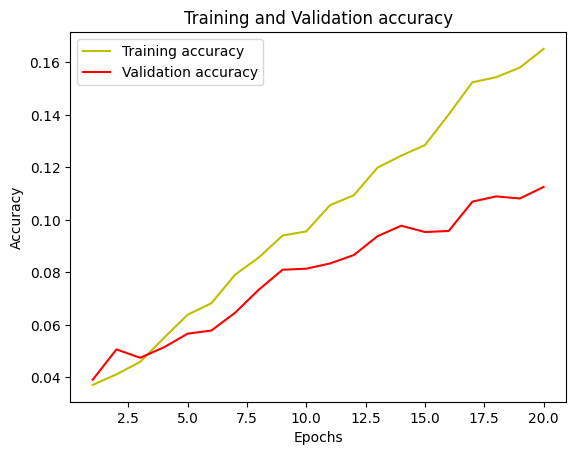

In [ ]:
import_results = import_images("no", 64, (96, 96))
model124 = build_model((3, [16, 32, 48]), (1,228), 0.0001, 0.6)
hist124 = train_model(model124, 20)
predictions(model124, 16, (96, 96))
history_model(hist124)

## Test learning rate

### Model 1.3.1. Simple CNN - image_size (96x96) - batch size=64 + LR(0.01)

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 194s 1s/step - loss: 4.5573 - accuracy: 0.0361 - val_loss: 4.5115 - val_accuracy: 0.0391
Epoch 2/20
179/179 [==============================] - 192s 1s/step - loss: 4.5196 - accuracy: 0.0372 - val_loss: 4.5090 - val_accuracy: 0.0391
Epoch 3/20
179/179 [==============================] - 163s 891ms/step - loss: 4.5176 - accuracy: 0.0386 - val_loss: 4.5074 - val_accuracy: 0.0391
Epoch 4/20
179/179 [==============================] - 162s 888ms/step - loss: 4.5162 - accuracy: 0.0383 - val_loss: 4.5076 - val_accuracy: 0.0391
Epoch 5/20
179/179 [==============================] - 167s 915ms/step - loss: 4.5143 - accuracy: 0.0382 - val_loss: 4.5059 - val_accuracy: 0.0391
Epoch 6/20
179/179 [==============================] - 163s 885ms/step - loss: 4.5139 - accuracy: 0.0382 - val_loss: 4.5058 - val_accuracy: 0.0391
Epoch 7/20
179/179 [=======================

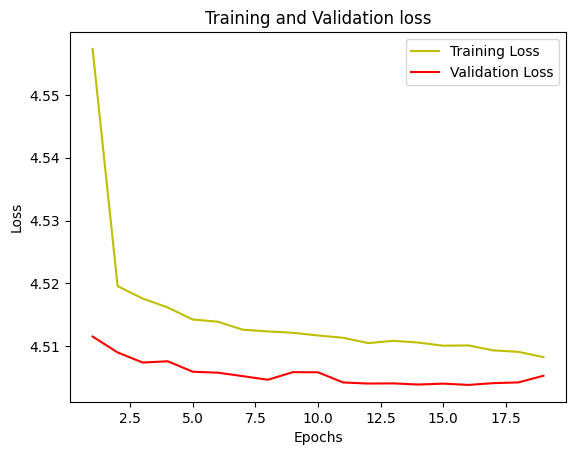

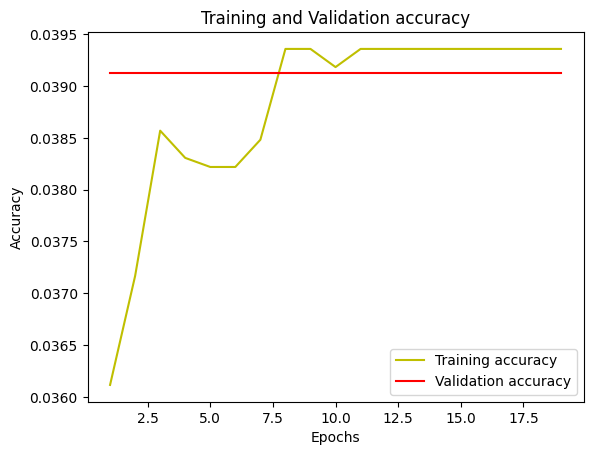

In [ ]:
import_results = import_images("no", 64, (96, 96))
model131 = build_model((3, [16, 32, 48]), (1,228), 0.01)
hist131 = train_model(model131, 20)
predictions(model131, 16, (96, 96))
history_model(hist131)

### Model 1.3.2. Simple CNN - image_size (96x96) - batch size=64 + LR(0.0001)

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 166s 901ms/step - loss: 4.5746 - accuracy: 0.0351 - val_loss: 4.5118 - val_accuracy: 0.0447
Epoch 2/20
179/179 [==============================] - 169s 929ms/step - loss: 4.4808 - accuracy: 0.0455 - val_loss: 4.4493 - val_accuracy: 0.0451
Epoch 3/20
179/179 [==============================] - 165s 901ms/step - loss: 4.3994 - accuracy: 0.0577 - val_loss: 4.3883 - val_accuracy: 0.0479
Epoch 4/20
179/179 [==============================] - 160s 878ms/step - loss: 4.3164 - accuracy: 0.0668 - val_loss: 4.3477 - val_accuracy: 0.0519
Epoch 5/20
179/179 [==============================] - 170s 925ms/step - loss: 4.2356 - accuracy: 0.0751 - val_loss: 4.3040 - val_accuracy: 0.0575
Epoch 6/20
179/179 [==============================] - 166s 910ms/step - loss: 4.1596 - accuracy: 0.0863 - val_loss: 4.2701 - val_accuracy: 0.0719
Epoch 7/20
179/179 [=================

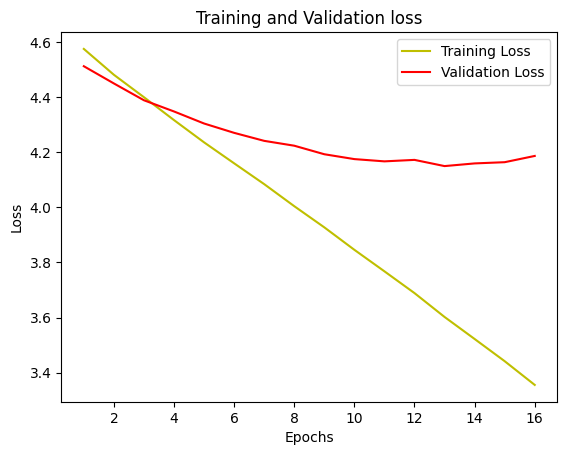

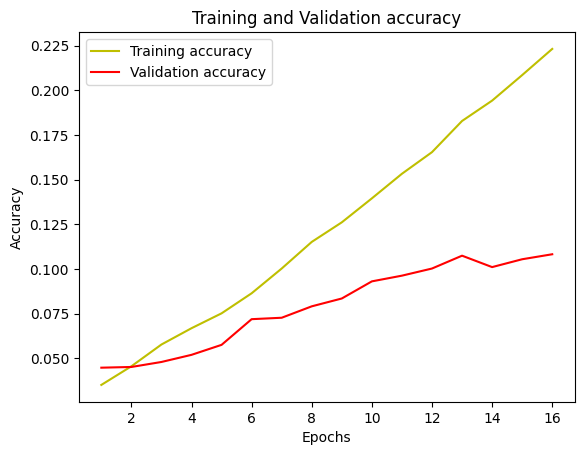

In [ ]:
import_results = import_images("no", 64, (96, 96))
model132 = build_model((3, [16, 32, 48]), (1,228), 0.0001)
hist132 = train_model(model132, 20)
predictions(model132, 16, (96, 96))
history_model(hist132)

### Model 1.3.3. Simple CNN - image_size (96x96) - batch size=64 + LR(0.00001)

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 165s 886ms/step - loss: 4.7074 - accuracy: 0.0280 - val_loss: 4.6631 - val_accuracy: 0.0375
Epoch 2/20
179/179 [==============================] - 164s 893ms/step - loss: 4.6220 - accuracy: 0.0393 - val_loss: 4.5870 - val_accuracy: 0.0391
Epoch 3/20
179/179 [==============================] - 182s 998ms/step - loss: 4.5698 - accuracy: 0.0394 - val_loss: 4.5538 - val_accuracy: 0.0391
Epoch 4/20
179/179 [==============================] - 161s 885ms/step - loss: 4.5458 - accuracy: 0.0394 - val_loss: 4.5348 - val_accuracy: 0.0395
Epoch 5/20
179/179 [==============================] - 158s 870ms/step - loss: 4.5287 - accuracy: 0.0394 - val_loss: 4.5208 - val_accuracy: 0.0395
Epoch 6/20
179/179 [==============================] - 164s 900ms/step - loss: 4.5156 - accuracy: 0.0394 - val_loss: 4.5102 - val_accuracy: 0.0403
Epoch 7/20
179/179 [=================

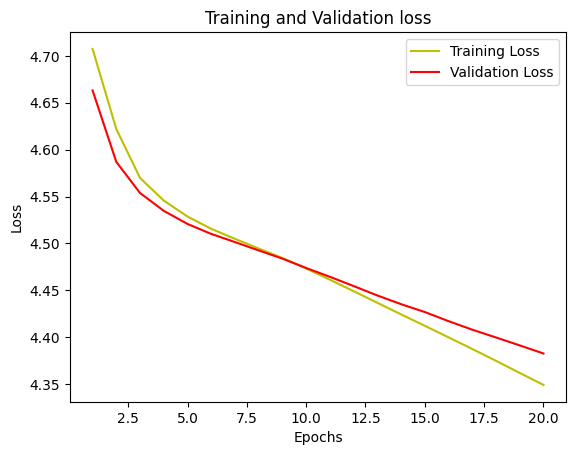

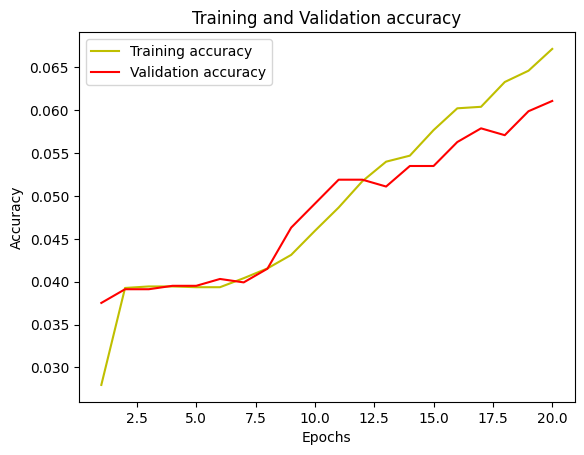

In [ ]:
import_results = import_images("no", 64, (96, 96))
model133 = build_model((3, [16, 32, 48]), (1,228), 0.00001)
hist133 = train_model(model133, 20)
predictions(model133, 16, (96, 96))
history_model(hist133)

### Model 1.3.4. Simple CNN - image_size (96x96) - batch size=64 + ReduceLROnPlateau

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 165s 892ms/step - loss: 4.5244 - accuracy: 0.0393 - val_loss: 4.4502 - val_accuracy: 0.0419 - lr: 0.0010
Epoch 2/20
179/179 [==============================] - 163s 892ms/step - loss: 4.3589 - accuracy: 0.0614 - val_loss: 4.3276 - val_accuracy: 0.0631 - lr: 0.0010
Epoch 3/20
179/179 [==============================] - 161s 875ms/step - loss: 4.1500 - accuracy: 0.0832 - val_loss: 4.2303 - val_accuracy: 0.0750 - lr: 0.0010
Epoch 4/20
179/179 [==============================] - 164s 903ms/step - loss: 3.9194 - accuracy: 0.1169 - val_loss: 4.1703 - val_accuracy: 0.0914 - lr: 0.0010
Epoch 5/20
179/179 [==============================] - 165s 904ms/step - loss: 3.6497 - accuracy: 0.1573 - val_loss: 4.2390 - val_accuracy: 0.0958 - lr: 0.0010
Epoch 6/20
179/179 [==============================] - 164s 903ms/step - loss: 3.3557 - accuracy: 0.2106 - val_loss: 4.

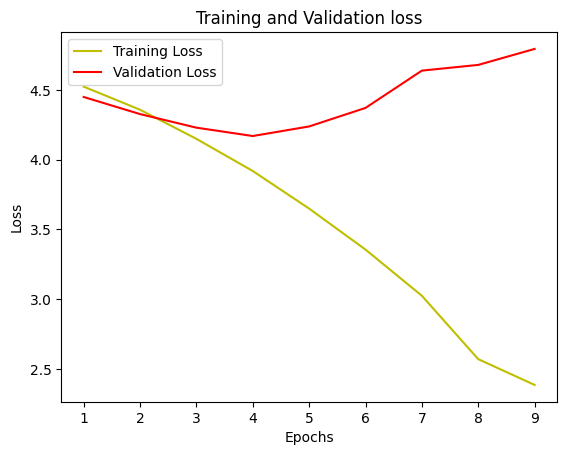

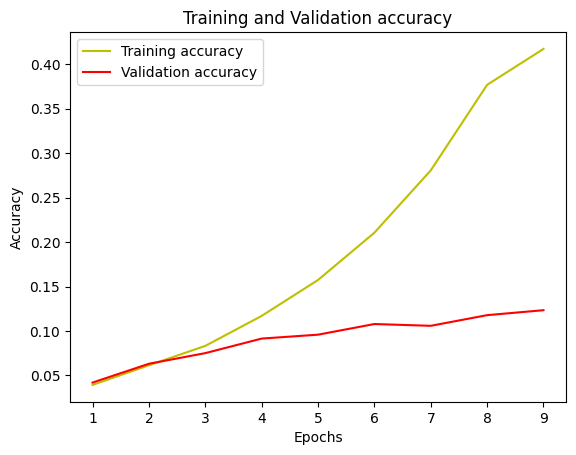

In [ ]:
import_results = import_images("no", 64, (96, 96))
model134 = build_model((3, [16, 32, 48]), (1,228), 0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
train_generator,val_generator, _ = import_results
hist134 = model134.fit(train_generator, callbacks=[reduce_lr, early_stopping_callback], epochs=20, validation_data=val_generator)
predictions(model134, 16, (96, 96))
history_model(hist134)

## Test data augmentation

### Model 1.4. Simple CNN - image_size (96x96) - batch size=64 + Random Augmentation

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 1797s 10s/step - loss: 4.6080 - accuracy: 0.0367 - val_loss: 4.5196 - val_accuracy: 0.0391
Epoch 2/20
179/179 [==============================] - 181s 986ms/step - loss: 4.5169 - accuracy: 0.0385 - val_loss: 4.5080 - val_accuracy: 0.0391
Epoch 3/20
179/179 [==============================] - 176s 964ms/step - loss: 4.5108 - accuracy: 0.0383 - val_loss: 4.5053 - val_accuracy: 0.0391
Epoch 4/20
179/179 [==============================] - 186s 1s/step - loss: 4.5089 - accuracy: 0.0394 - val_loss: 4.5048 - val_accuracy: 0.0391
Epoch 5/20
179/179 [==============================] - 176s 962ms/step - loss: 4.5079 - accuracy: 0.0394 - val_loss: 4.5039 - val_accuracy: 0.0391
Epoch 6/20
179/179 [==============================] - 171s 937ms/step - loss: 4.5078 - accuracy: 0.0394 - val_loss: 4.5038 - val_accuracy: 0.0391
Epoch 7/20
179/179 [=====================

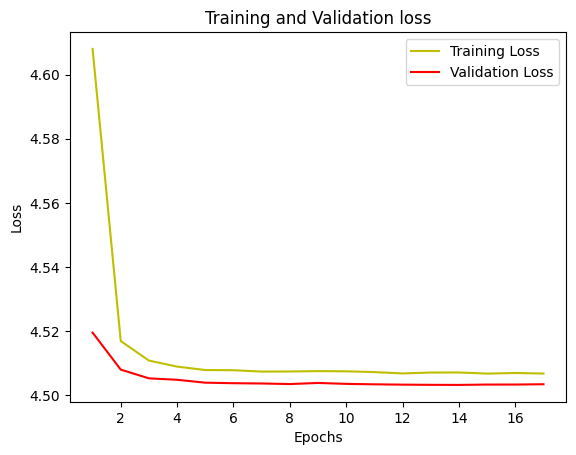

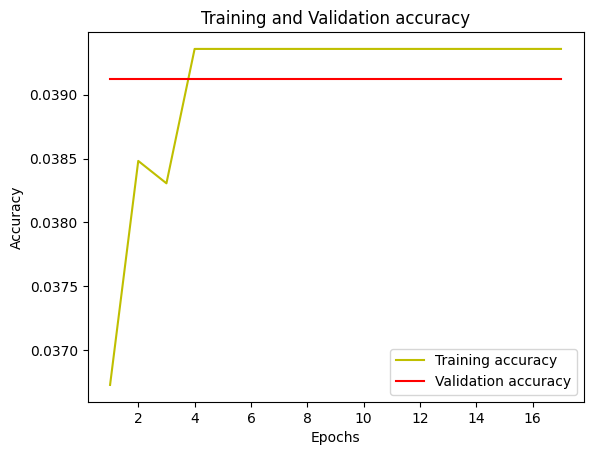

In [ ]:
import_results = import_images('no', 64, (96, 96))
model14 = Sequential([
    Rescaling(1./255, input_shape = (96, 96, 3)),
    RandomRotation(factor=0.1),
    RandomZoom(height_factor=0.2, width_factor=0.2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(48, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(228, activation='relu'),
    Dense(114, activation='softmax')
])
model14.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist14 = train_model(model14, 20)
predictions(model14, 16, (96, 96))
history_model(hist14)

### Model 1.5. Simple CNN - image_size (96x96) - batch size=64 - Imbalance augmentation

Found 18319 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
287/287 [==============================] - 4836s 16s/step - loss: 4.4518 - accuracy: 0.0301 - val_loss: 4.6952 - val_accuracy: 0.0204
Epoch 2/20
287/287 [==============================] - 237s 814ms/step - loss: 4.3262 - accuracy: 0.0483 - val_loss: 4.6176 - val_accuracy: 0.0427
Epoch 3/20
287/287 [==============================] - 224s 774ms/step - loss: 4.2309 - accuracy: 0.0648 - val_loss: 4.5708 - val_accuracy: 0.0495
Epoch 4/20
287/287 [==============================] - 229s 789ms/step - loss: 4.1374 - accuracy: 0.0819 - val_loss: 4.5029 - val_accuracy: 0.0591
Epoch 5/20
287/287 [==============================] - 226s 779ms/step - loss: 4.0512 - accuracy: 0.0931 - val_loss: 4.4905 - val_accuracy: 0.0523
Epoch 6/20
287/287 [==============================] - 228s 787ms/step - loss: 3.9728 - accuracy: 0.1039 - val_loss: 4.4067 - val_accuracy: 0.0703
Epoch 7/20
287/287 [==================

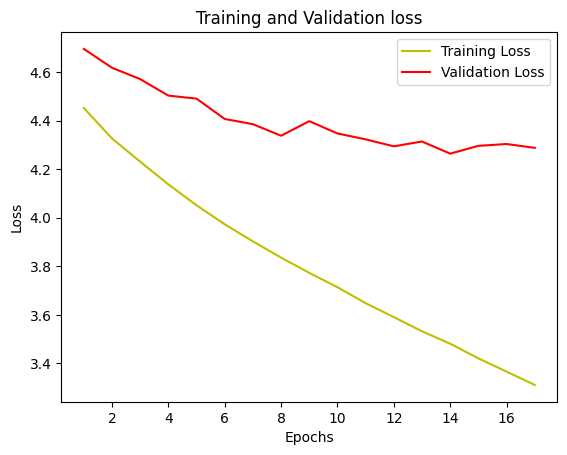

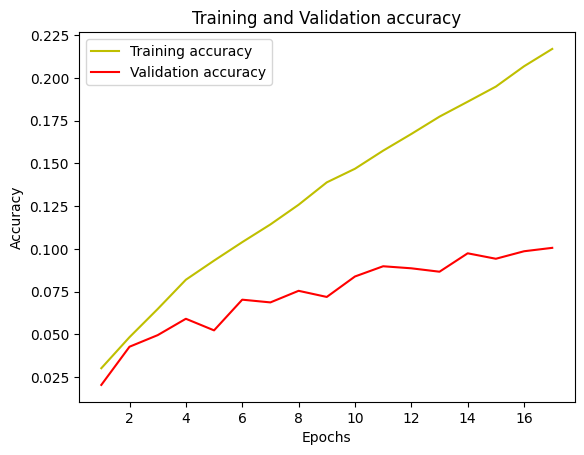

In [ ]:
import_results = import_images("yes", 64, (96, 96))
model15 = build_model((3, [16, 32, 48]), (1,228))
hist15 = train_model(model15, 20)
predictions(model15, 16, (96, 96))
history_model(hist15)

## Test batch normalization

### Model 1.6. Simple CNN - image_size (150x150) - Batch normalization

Found 11408 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
179/179 [==============================] - 228s 1s/step - loss: 4.6415 - accuracy: 0.0543 - val_loss: 5.4266 - val_accuracy: 0.0180
Epoch 2/20
179/179 [==============================] - 202s 1s/step - loss: 4.1044 - accuracy: 0.1070 - val_loss: 4.9329 - val_accuracy: 0.0259
Epoch 3/20
179/179 [==============================] - 203s 1s/step - loss: 3.5830 - accuracy: 0.1752 - val_loss: 5.0058 - val_accuracy: 0.0387
Epoch 4/20
179/179 [==============================] - 224s 1s/step - loss: 2.9210 - accuracy: 0.2948 - val_loss: 4.6623 - val_accuracy: 0.0822
Epoch 5/20
179/179 [==============================] - 219s 1s/step - loss: 2.0997 - accuracy: 0.4778 - val_loss: 6.1044 - val_accuracy: 0.0479
Epoch 6/20
179/179 [==============================] - 200s 1s/step - loss: 1.2881 - accuracy: 0.6714 - val_loss: 6.0052 - val_accuracy: 0.0535
Epoch 7/20
179/179 [==============================] - 2

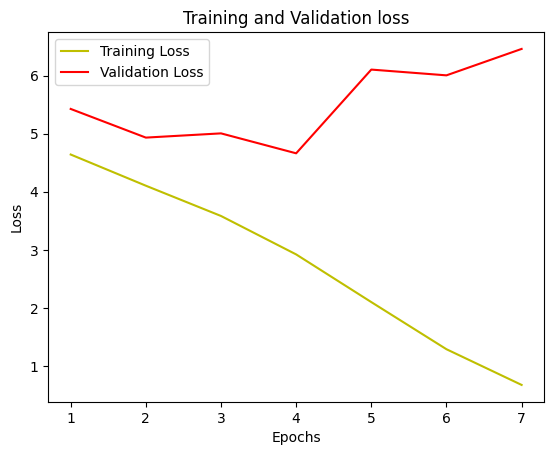

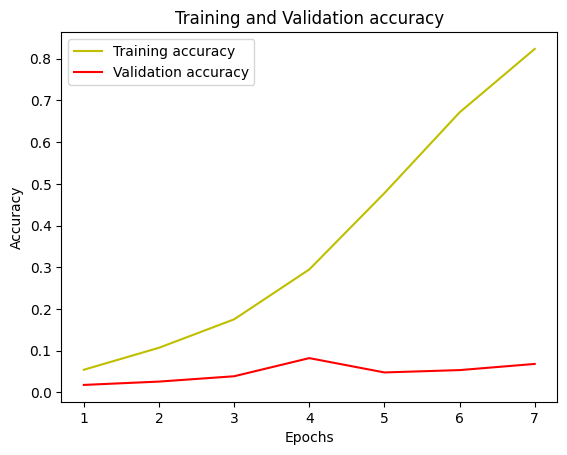

In [ ]:
import_results = import_images('no', 64, (96, 96))
model16 = Sequential([
    Conv2D(16, (3, 3), input_shape = (96, 96, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(48, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(228, activation='relu'),
    Dense(114, activation='softmax')
])
model16.compile(optimizer=RMSprop(learning_rate=0.001) , loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist16 = train_model(model16, 20)
predictions(model16, 16, (96, 96))
history_model(hist16)